In [25]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import pickle

#### TASK 2: Load the MNIST Dataset

In [12]:
# Function to load MNIST images
def load_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows * cols)
    return images

# Function to load MNIST labels
def load_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

In [13]:
# Load train and test data
train_images = load_images('train-images-idx3-ubyte')
train_labels = load_labels('train-labels-idx1-ubyte')
test_images = load_images('t10k-images-idx3-ubyte')
test_labels = load_labels('t10k-labels-idx1-ubyte')

#### TASK 3: Reshape and visualize the images

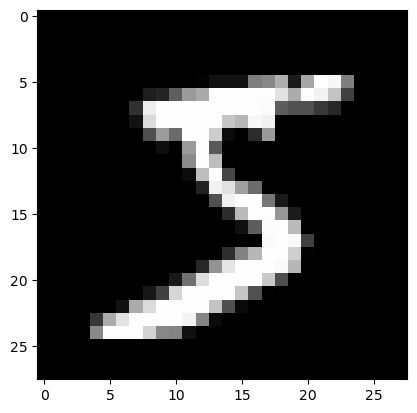

In [14]:
# Function to reshape a flat array into a 28x28 image for visualization
def reshape_and_visualize(image_data, index):
    img = image_data[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

# Example visualization
reshape_and_visualize(train_images, 0)  # Visualize the first training image


#### TASK 4: Structure the Network

In [15]:
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_size=512, output_size=10):
        # Initialize weights and biases
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    # Forward pass function
    def forward(self, x):
        self.hidden_input = np.dot(x, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.relu(self.hidden_input)
        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.output = self.softmax(self.output_input)
        return self.output


#### TASK 5: Instantiate the neural network with initialized weights



In [16]:
nn = NeuralNetwork()

#### Task 6: Implement a Forward Pass

In [17]:
# Forward pass for one image
sample_image = train_images[0] / 255.0  # Normalize the pixel values
output = nn.forward(sample_image.reshape(1, -1))  # Flatten the image and pass to the network
print(f"Predicted output: {output}")

Predicted output: [[0.10165559 0.1008904  0.09850876 0.09940342 0.10169916 0.09980944
  0.1007393  0.09848906 0.09893541 0.09986946]]


#### Task 7: Implement a Loss Function (Cross Entropy Loss Function)

In [18]:
# Cross-entropy loss function
def cross_entropy_loss(predictions, labels):
    return -np.sum(labels * np.log(predictions + 1e-8)) / labels.shape[0]

# Prepare a sample label (one-hot encoded)
sample_label = np.zeros((1, 10))
sample_label[0, train_labels[0]] = 1

# Compute loss for one sample
loss = cross_entropy_loss(output, sample_label)
print(f"Loss: {loss}")

Loss: 2.3044924573649905


#### Task 8: Implement Backpropagation and Gradient Descent

In [20]:
# Backpropagation function
def backpropagate(nn, x, y, learning_rate=0.001):
    # Forward pass (already implemented)
    output = nn.forward(x)

    # Calculate output layer error
    output_error = output - y  # dL/dZ (softmax error)
    
    # Backpropagate to hidden layer
    hidden_error = np.dot(output_error, nn.weights_hidden_output.T) * (nn.hidden_output > 0)  # dL/dA (ReLU derivative)
    
    # Gradients for weights and biases
    grad_who = np.dot(nn.hidden_output.T, output_error)
    grad_b_o = np.sum(output_error, axis=0, keepdims=True)
    grad_wih = np.dot(x.T, hidden_error)
    grad_b_h = np.sum(hidden_error, axis=0, keepdims=True)
    
    # Gradient descent update
    nn.weights_hidden_output -= learning_rate * grad_who
    nn.bias_output -= learning_rate * grad_b_o
    nn.weights_input_hidden -= learning_rate * grad_wih
    nn.bias_hidden -= learning_rate * grad_b_h

# Example backpropagation run for one sample
backpropagate(nn, sample_image.reshape(1, -1), sample_label)


#### TASK 9: Improved Initialization (He Initialization)

In [21]:
def he_initialization(size_in, size_out):
    return np.random.randn(size_in, size_out) * np.sqrt(2 / size_in)

# Reinitialize weights with He initialization
nn.weights_input_hidden = he_initialization(784, 512)
nn.weights_hidden_output = he_initialization(512, 10)


#### Task 10: Implement Momentum

In [22]:
class MomentumNeuralNetwork(NeuralNetwork):
    def __init__(self, input_size=784, hidden_size=512, output_size=10, momentum=0.9):
        super().__init__(input_size, hidden_size, output_size)
        self.momentum = momentum
        self.v_wih = np.zeros_like(self.weights_input_hidden)
        self.v_who = np.zeros_like(self.weights_hidden_output)

    def update_with_momentum(self, grad_wih, grad_who, learning_rate):
        self.v_wih = self.momentum * self.v_wih - learning_rate * grad_wih
        self.v_who = self.momentum * self.v_who - learning_rate * grad_who
        self.weights_input_hidden += self.v_wih
        self.weights_hidden_output += self.v_who

# Example usage with momentum
momentum_nn = MomentumNeuralNetwork()


#### Task 11: Overfitting and Validation

In [23]:
# Split the dataset into training and validation sets (75% train, 25% validation)
split_idx = int(0.75 * len(train_images))
train_X, val_X = train_images[:split_idx], train_images[split_idx:]
train_y, val_y = train_labels[:split_idx], train_labels[split_idx:]

# Monitor loss on both train and validation sets to decide when to stop training
def evaluate_loss(nn, X, y):
    predictions = nn.forward(X)
    one_hot_labels = np.zeros((y.size, 10))
    one_hot_labels[np.arange(y.size), y] = 1
    return cross_entropy_loss(predictions, one_hot_labels)

# Example of training loss vs validation loss
train_loss = evaluate_loss(nn, train_X[:100] / 255.0, train_y[:100])
val_loss = evaluate_loss(nn, val_X[:100] / 255.0, val_y[:100])
print(f"Training loss: {train_loss}, Validation loss: {val_loss}")


Training loss: 2.404913076669037, Validation loss: 2.338686193410849


### Full Code for the Training Loop with Momentum, Early Stopping, and Mini-batch Updates

In [26]:
class MomentumNeuralNetwork:
    def __init__(self, input_size=784, hidden_size=512, output_size=10, momentum=0.9):
        # Initialize weights and biases with He initialization
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        self.bias_output = np.zeros((1, output_size))
        
        # Initialize velocities for momentum
        self.momentum = momentum
        self.velocity_wih = np.zeros_like(self.weights_input_hidden)
        self.velocity_who = np.zeros_like(self.weights_hidden_output)
        self.velocity_bh = np.zeros_like(self.bias_hidden)
        self.velocity_bo = np.zeros_like(self.bias_output)

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward(self, x):
        self.hidden_input = np.dot(x, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.relu(self.hidden_input)
        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.output = self.softmax(self.output_input)
        return self.output

    def backpropagate(self, x, y, learning_rate=0.001):
        # Forward pass (already implemented)
        output = self.forward(x)

        # Calculate output layer error
        output_error = output - y  # dL/dZ for the output layer
        
        # Backpropagate to hidden layer
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * (self.hidden_output > 0)

        # Gradients for weights and biases
        grad_who = np.dot(self.hidden_output.T, output_error)
        grad_b_o = np.sum(output_error, axis=0, keepdims=True)
        grad_wih = np.dot(x.T, hidden_error)
        grad_b_h = np.sum(hidden_error, axis=0, keepdims=True)

        # Momentum-based weight updates
        self.velocity_who = self.momentum * self.velocity_who - learning_rate * grad_who
        self.velocity_bo = self.momentum * self.velocity_bo - learning_rate * grad_b_o
        self.velocity_wih = self.momentum * self.velocity_wih - learning_rate * grad_wih
        self.velocity_bh = self.momentum * self.velocity_bh - learning_rate * grad_b_h
        
        # Update weights and biases
        self.weights_hidden_output += self.velocity_who
        self.bias_output += self.velocity_bo
        self.weights_input_hidden += self.velocity_wih
        self.bias_hidden += self.velocity_bh

# Cross-entropy loss function
def cross_entropy_loss(predictions, labels):
    return -np.mean(np.sum(labels * np.log(predictions + 1e-8), axis=1))

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot

# Function to create mini-batches
def create_mini_batches(X, y, batch_size):
    indices = np.random.permutation(X.shape[0])
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    mini_batches = [(X_shuffled[i:i + batch_size], y_shuffled[i:i + batch_size]) 
                    for i in range(0, X.shape[0], batch_size)]
    return mini_batches

# Function to evaluate loss on a dataset
def evaluate_loss(nn, X, y):
    predictions = nn.forward(X)
    return cross_entropy_loss(predictions, y)

# Function to train the model with early stopping
def train(nn, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate=0.001, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Shuffle and create mini-batches
        mini_batches = create_mini_batches(X_train, y_train, batch_size)
        
        # Train on each mini-batch
        for X_batch, y_batch in mini_batches:
            nn.backpropagate(X_batch, y_batch, learning_rate)

        # Compute training and validation loss
        train_loss = evaluate_loss(nn, X_train, y_train)
        val_loss = evaluate_loss(nn, X_val, y_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model state
            save_model(nn, "best_model.pkl")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses

# Function to save the model
def save_model(nn, filename):
    with open(filename, 'wb') as file:
        pickle.dump(nn, file)
    print(f"Model saved to {filename}")

# Function to load a model
def load_model(filename):
    with open(filename, 'rb') as file:
        nn = pickle.load(file)
    print(f"Model loaded from {filename}")
    return nn

# Visualization function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


### Training the Model

Epoch 1/50 - Training Loss: 0.1034, Validation Loss: 0.1338
Model saved to best_model.pkl
Epoch 2/50 - Training Loss: 0.0613, Validation Loss: 0.1018
Model saved to best_model.pkl
Epoch 3/50 - Training Loss: 0.0401, Validation Loss: 0.0921
Model saved to best_model.pkl
Epoch 4/50 - Training Loss: 0.0278, Validation Loss: 0.0848
Model saved to best_model.pkl
Epoch 5/50 - Training Loss: 0.0171, Validation Loss: 0.0758
Model saved to best_model.pkl
Epoch 6/50 - Training Loss: 0.0119, Validation Loss: 0.0789
Epoch 7/50 - Training Loss: 0.0067, Validation Loss: 0.0775
Epoch 8/50 - Training Loss: 0.0065, Validation Loss: 0.0813
Epoch 9/50 - Training Loss: 0.0029, Validation Loss: 0.0744
Model saved to best_model.pkl
Epoch 10/50 - Training Loss: 0.0021, Validation Loss: 0.0742
Model saved to best_model.pkl
Epoch 11/50 - Training Loss: 0.0018, Validation Loss: 0.0759
Epoch 12/50 - Training Loss: 0.0020, Validation Loss: 0.0794
Epoch 13/50 - Training Loss: 0.0012, Validation Loss: 0.0762
Epoch 

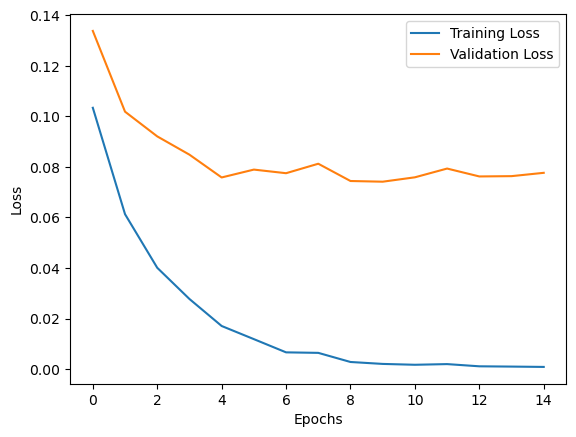

Model loaded from best_model.pkl
Test Loss: 0.06533116639492657


In [27]:
# Load and preprocess the data
train_images = train_images / 255.0  # Normalize to range [0, 1]
test_images = test_images / 255.0

train_labels_one_hot = one_hot_encode(train_labels)
test_labels_one_hot = one_hot_encode(test_labels)

# Split into training and validation sets (75% training, 25% validation)
split_idx = int(0.75 * len(train_images))
X_train, X_val = train_images[:split_idx], train_images[split_idx:]
y_train, y_val = train_labels_one_hot[:split_idx], train_labels_one_hot[split_idx:]

# Create a neural network
nn = MomentumNeuralNetwork()

# Train the model
train_losses, val_losses = train(nn, X_train, y_train, X_val, y_val, epochs=50, batch_size=64, learning_rate=0.001, patience=5)

# Plot the training and validation loss
plot_losses(train_losses, val_losses)

# Load the best saved model (optional)
best_model = load_model("best_model.pkl")

# Test the model on test data
test_loss = evaluate_loss(best_model, test_images, test_labels_one_hot)
print(f"Test Loss: {test_loss}")
